In [1]:
# Python Package Imports
import os
import numpy as np
import scipy.fftpack as fft
import numpy.random as rnd
import random
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd

# Preamble

## Introduction
This notebook is to show how to do sprinkler data processing, and to generate TDOA observations between two receivers. 

# Notes
The data used here was collected with an intentional intereference source. It was collected on one of the NovAtel Metris test vehicles, which means that the baseline between receivers was <5m. As I will show in the next cell, the minimum spacing for Sprinkler to be effective is much larger than this

In [2]:
c = 299792458 # m/s, speed of light
sample_rate = 12000000 # SPS according to the Paper 
sample_spacing = c/sample_rate
print(f'The minimum spacing between receivers should be: {sample_spacing}m')

The minimum spacing between receivers should be: 24.982704833333333m


# Function definitions

In [3]:
def get_obs_from_files(obs_filenames, start_loc=1, max_size=10000):
    """
    Function for retrieving the sprinkler observations from the file given. Places each parsed log in to a list
    Args: 
        obs_filenames (list of str): List of filenames to parse. 
        start_loc (int): The start location to parse. Use if you want to skip the start of the file for some reason
        max_size (int): The end location to parse. Use to limit size, or to stop before the end of file. 
    """
    obs_arrays = []
    for obs_filename in obs_filenames:
        with open(obs_filename, 'r+') as datafile: 
            print(f'Reading {obs_filename}...')
            raw_sprinkles = datafile.readlines()
            print('Done')
        spkrlr_data = [log.split(',') for log in raw_sprinkles[start_loc:start_loc+max_size]]
        obs_arrays.append(spkrlr_data)
    return obs_arrays

In [4]:
def get_series_from_log(log):
    """ Function to return a series from an individual sprinkler log """
    series = [int(dat) for dat in log[8:-4]]
    return series

In [5]:
def get_all_epoch_in_logs(logs):
    """Function to return all the unique epochs present in the logs """
    epochs = []
    for log in logs: 
        epoch = get_epoch_from_log(log)
        if epoch not in epochs:
            epochs.append(epoch)
            
    return epochs

In [6]:
def get_pos_from_log(log):
    """ Simple function to extrac the location from a log """
    pos_E = float(log[-3])
    pos_N = float(log[-2])
    pos_U = float(log[-1])
    return pos_E, pos_N, pos_U

In [7]:
def get_epoch_from_log(log):
    """ Simple function to extract the epoch of a specific log """
    epoch = float(log[0])
    return epoch

In [8]:
def complexify(sig):
    """ Given a list (sig), make every second value the imaginary value of a complex number """
    i=[]
    q=[]
    for j in range(len(sig)):
        if j%2 == 0:
            i.append(sig[j])
        else:
            q.append(sig[j])
    i = np.array(i)
    q = np.array(q)
    return (i + 1j*q)

In [9]:
def fft_ccor(a, b):
    """ 
    Complete the cross correlation of signal a to signal b. This uses the scipy.fftpack function. 
    
    Equation: cross_correlation = inv_fft(fft(sig_a) + conjugate(fft(sig_b)))
    
    """
    fft_a = fft.fft(a)
    fft_b = np.conj((fft.fft(b)))
    fft_crosscorr = np.fft.fftshift(np.fft.ifft(fft_a * fft_b))
    return fft_crosscorr

In [10]:
def get_corr_axis(corr_array):
    """ Creates the horizontal axis ticks, with 0 centered (to plot the correlation shift)"""
    half_size = int(len(corr_array)/2)
    if half_size*2 < len(corr_array):
        x = np.arange(-half_size, half_size+1)
    elif half_size*2 > len(corr_array):
        x = np.arange(-half_size, half_size-1)
    else:
        x = np.arange(-half_size, half_size)
    return x
    

In [11]:
def get_corr_offset(log1, log2, epoch):
    """ 
        Find the value of the correlation at the peak of the correlation spike (normalized to max value). The real portion of the correlation
        is used here, as the imaginary value is to do with power of the correlated signal and is not useful. 
        
        Todo: Find reference for this
    
    """
    rx_epoch_obs = []
    corr_epoch = epoch
    for rx_file in [log1, log2]: 
        epoch_series = []
        for log in rx_file:
            if get_epoch_from_log(log) == corr_epoch:
                epoch_series.extend(get_series_from_log(log))
        rx_epoch_obs.append(epoch_series)

    complex_rx_series = []
    for series in rx_epoch_obs:
        complex_rx_series.append(complexify(series))

    corr = fft_ccor(complex_rx_series[0],complex_rx_series[1])
    corr.real /= np.max(abs(corr.real))
    x = get_corr_axis(corr)
    max_shift = x[np.argmax(corr.real)]
#     print(f'Location of max: {max_shift}')
    return abs(corr.real), x

In [12]:
def check_for_corr(corr_series, thresh=7):
    """ Simple function to check if a correlation was found """
    base = np.mean(corr_series)
    spike_max = np.max(corr_series)
    return (spike_max/base)>thresh

# Two receiver correlation
### Using two receivers, correlate the output sprinkler data. 
#### The expected result is a cross correlation spike, indicating that the two datasets are in fact being affected by the same interference source

In [13]:
# Find all the filenames in the directory that end with .csv
# file_loc = f"/home/edmond/Documents/Projects/Sandbox/DataSandbox/Observations/"
file_loc = f"/mnt/BigSlowBoi/DOCUMENTS/Projects/InterferenceGeolocation/Sprinkler/Data/Observations"
obs_filenames = [os.path.join(file_loc,f) for f in os.listdir(file_loc) if f.endswith('.csv')]

In [14]:
# Read in observations from the filenames
# Starting at 1000, as the middle of the file is better
obs_arrays = get_obs_from_files(obs_filenames, start_loc = 1000)

Reading /mnt/BigSlowBoi/DOCUMENTS/Projects/InterferenceGeolocation/Sprinkler/Data/Observations/Observation_rx_1.csv...
Done
Reading /mnt/BigSlowBoi/DOCUMENTS/Projects/InterferenceGeolocation/Sprinkler/Data/Observations/Observation_rx_2.csv...
Done
Reading /mnt/BigSlowBoi/DOCUMENTS/Projects/InterferenceGeolocation/Sprinkler/Data/Observations/Observation_rx_0.csv...
Done


In [15]:
# get all the epochs that are found in the file
epochs = get_all_epoch_in_logs(obs_arrays[0])

In [142]:
# DEBUG PANDAS STUFF
test_array =  obs_arrays[0]
arr_head = [t[:8] for t in test_array]
payload = [get_series_from_log(t) for t in test_array]
obs_df_1 = pd.DataFrame(arr_head)
obs_df_1 = obs_df_1.apply(pd.to_numeric)
test_array =  obs_arrays[2]
arr_head = [t[:8] for t in test_array]
payload = [get_series_from_log(t) for t in test_array]
obs_df_2 = pd.DataFrame(arr_head)
obs_df_2 = obs_df_2.apply(pd.to_numeric)
obs_df_1.columns = ['Second', 'Week', 'Lat', 'Lon', 'Height', 'DataLen', 'Samples', 'AlsoLen']
obs_df_2.columns = ['Second', 'Week', 'Lat', 'Lon', 'Height', 'DataLen', 'Samples', 'AlsoLen']

In [173]:

class Epoch:
    def __init__(self, week, second):
        self.week = week
        self.second = second
    def __eq__(self, eq_class):
        return self.week == eq_class.week and self.second == eq_class.second
    
    def __hash__(self):
        return hash((self.week, self.second))
    def __repr__(self):
        return f'{self.week}:{self.second}'

In [174]:
s_new = list(obs_df_1['Second'])
w_new = list(obs_df_1['Week'])

In [175]:
eps = [Epoch(e[0], e[1]) for e in list(zip(w_new, s_new))]

In [176]:
len(eps)

10000

In [177]:
set(eps)

{2136:441703.0,
 2136:441704.0,
 2136:441705.0,
 2136:441706.0,
 2136:441707.0,
 2136:441708.0,
 2136:441709.0,
 2136:441710.0,
 2136:441711.0,
 2136:441712.0,
 2136:441713.0,
 2136:441714.0,
 2136:441715.0,
 2136:441716.0,
 2136:441717.0,
 2136:441718.0,
 2136:441719.0,
 2136:441720.0,
 2136:441721.0,
 2136:441722.0,
 2136:441723.0,
 2136:441724.0,
 2136:441725.0,
 2136:441726.0,
 2136:441727.0,
 2136:441728.0,
 2136:441729.0,
 2136:441730.0,
 2136:441731.0,
 2136:441732.0,
 2136:441733.0,
 2136:441734.0,
 2136:441735.0,
 2136:441736.0,
 2136:441737.0,
 2136:441738.0,
 2136:441739.0,
 2136:441740.0,
 2136:441741.0,
 2136:441742.0,
 2136:441743.0,
 2136:441744.0,
 2136:441745.0,
 2136:441746.0,
 2136:441747.0,
 2136:441748.0,
 2136:441749.0,
 2136:441750.0,
 2136:441751.0,
 2136:441752.0,
 2136:441753.0,
 2136:441754.0,
 2136:441755.0,
 2136:441756.0,
 2136:441757.0,
 2136:441758.0,
 2136:441759.0,
 2136:441760.0,
 2136:441761.0,
 2136:441762.0,
 2136:441763.0,
 2136:441764.0,
 2136:44

In [21]:
# Create correlation series for each epoch
corrs = []
for i, epoch in enumerate(epochs[:100]):
    corr_array = get_corr_offset(obs_arrays[0], obs_arrays[2], epoch)
    res = check_for_corr(corr_array[0])
    corrs.append((corr_array, res))
    print(f'Epoch: {epoch} Corr detected: {res}')

Epoch: 441703.0 Corr detected: False
Epoch: 441704.0 Corr detected: True
Epoch: 441705.0 Corr detected: True
Epoch: 441706.0 Corr detected: True
Epoch: 441707.0 Corr detected: False
Epoch: 441708.0 Corr detected: True
Epoch: 441709.0 Corr detected: False
Epoch: 441710.0 Corr detected: False
Epoch: 441711.0 Corr detected: False
Epoch: 441712.0 Corr detected: True
Epoch: 441713.0 Corr detected: True
Epoch: 441714.0 Corr detected: True
Epoch: 441715.0 Corr detected: True
Epoch: 441716.0 Corr detected: False
Epoch: 441717.0 Corr detected: False
Epoch: 441718.0 Corr detected: True
Epoch: 441719.0 Corr detected: False
Epoch: 441720.0 Corr detected: True
Epoch: 441721.0 Corr detected: True
Epoch: 441722.0 Corr detected: True
Epoch: 441723.0 Corr detected: False
Epoch: 441724.0 Corr detected: True
Epoch: 441725.0 Corr detected: False
Epoch: 441726.0 Corr detected: False
Epoch: 441727.0 Corr detected: False
Epoch: 441728.0 Corr detected: True
Epoch: 441729.0 Corr detected: False
Epoch: 441730.0

# Example of what the correlation plot looks like for an epoch

## Without correlation

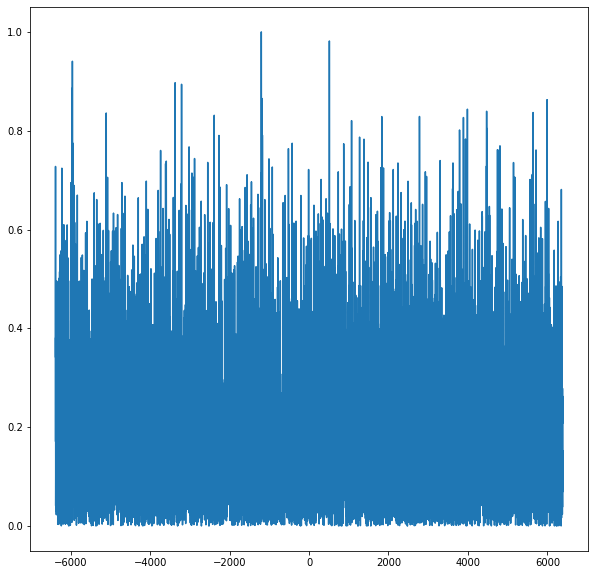

In [22]:
epoch = 0
plt.figure(figsize=(10,10))
plt.plot(corrs[epoch][0][1], corrs[epoch][0][0].real)
max_loc = corrs[epoch][0][1][np.argmax(corrs[epoch][0][0].real)]
# plt.xlim([max_loc-10,max_loc+10])

## With correlation Detected

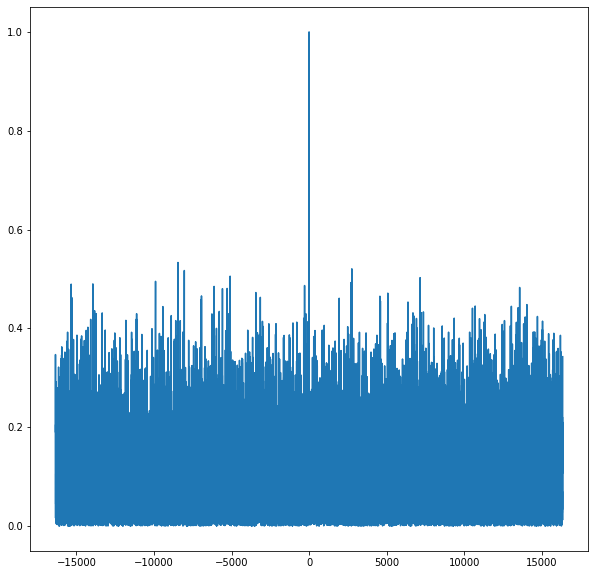

In [23]:
epoch = 2
plt.figure(figsize=(10,10))
plt.plot(corrs[epoch][0][1], corrs[epoch][0][0].real)
max_loc = corrs[epoch][0][1][np.argmax(corrs[epoch][0][0].real)]
# plt.xlim([max_loc-10,max_loc+10])

# Plot all epochs with correlation detected

## What are we trying to see here? 
The idea is that since the receivers were not very far away from each other (<5m) we should not be able to see much difference in the location of the correlation spike.
However, if the interference source was directly located in line with the two receivers, you might be able to see the correlation peak slip by 1 cycle. 

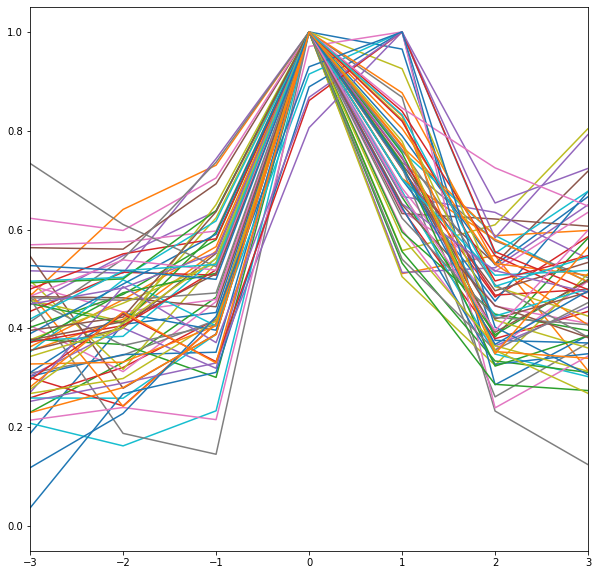

In [65]:
plt.figure(figsize=(10,10))
for corr in corrs:
    if corr[1]:
        max_loc = corr[0][1][np.argmax(corr[0][0].real)]
#         print(f'Max at: {max_loc}')
        plt.plot(corr[0][1], abs(corr[0][0].real))

plt.xlim([-3,3])
plt.show()

# Success!
That is exacly what we see here. Note that when the correlation peak is at 1, the secondary peak is nearly at the same correlation value. This is expected, because the true peak is somewhere in the middle (1 cycle is about 24 m)